# Setup

## imports

In [7]:
import os
import sys
import time

for model

In [8]:
# VGG
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, SimpleRNN
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint

In [9]:
# RESNET
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Flatten
from keras.layers.pooling import GlobalMaxPool2D, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam
from keras.applications.resnet50 import decode_predictions

In [10]:
from keras.applications import Xception

In [11]:
from keras import backend as K
K.set_image_dim_ordering('tf') # for Xception
# K.set_image_dim_ordering('th') # for ResNet

for plotting and misc

In [12]:
# setup matplotlib to display plots in the notebook
%matplotlib inline

# third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setup display options
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 400
pd.options.display.float_format = '{:,.5g}'.format
np.set_printoptions(precision=5, suppress=False)

# setup seaborn to use matplotlib defaults & styles
sns.set()
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})

## paths

In [13]:
pwd = os.getcwd().replace("notebooks","")
pwd

'/mnt/seals/'

In [46]:
path_models = pwd + 'models/'

# for previewing data augmentation output:
path_preview = pwd + 'data/preview/' 

path_data = pwd + 'data/images/'
#path_data = pwd + 'data/images_blurred/'

path_data_train = path_data +'train/'
path_data_valid = path_data +'valid/'
path_data_test = path_data +'test/'
# output
path_data_train, path_data_valid, path_data_test

('/mnt/seals/data/images/train/',
 '/mnt/seals/data/images/valid/',
 '/mnt/seals/data/images/test/')

## setup image size

In [15]:
# dimension our images will be rescaled to (default size for VGG)
img_width, img_height = 299, 299

# View some of the data

In [74]:
def plot_pic(imgpath):
    img= plt.imread(imgpath)
    imgplot = plt.imshow(img)
    plt.show()

In [17]:
def plot_pic_grid(path, filenames, add_title=True):
    # set figsize
    fig = plt.figure()
    fig.set_size_inches((16,8))

    plotted = 0

    for c, r in enumerate(filenames):

        # get path to image file 
        img_path_on_disk = path + r

        if len(img_path_on_disk) > 0:    

            if plotted < 10:

                plotted+=1

                # plotting 10 images
                a = fig.add_subplot(2, 5, (plotted))
                img= plt.imread(img_path_on_disk)
                imgplot = a.imshow(img)
                if add_title: 
                    a.set_title(r)

                #print user_id, 'image plotted'
        else:
            # print user_id, 'no pic available'
            pass

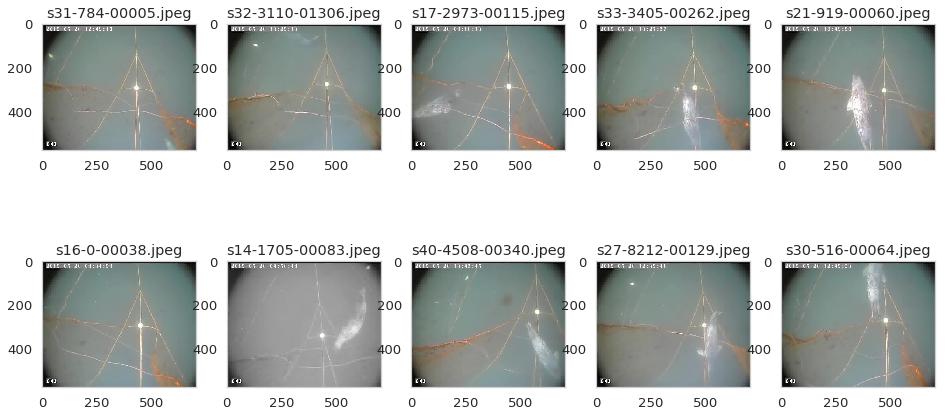

In [18]:
plot_pic_grid(path_data_train + '/seal/', os.listdir(path_data_train + 'seal/')[:10])

# Convert data back into sequence for video classification

## read list of paths across train/val/test and seal / no seal folders

In [47]:
paths_jpgs = []
for folder, subs, files in os.walk(path_data):        
    for filename in files:
        if filename[-4:] == '.jpg' or  filename[-4:] == 'jpeg':
            paths_jpgs.append(os.path.abspath(os.path.join(folder, filename)))

In [51]:
# create dataframe from paths
dfp = pd.DataFrame(paths_jpgs)
dfp.columns = ['path']
dfp['label'] = dfp['path'].str.split("/").str.get(-2)
dfp['filename'] = dfp['path'].str.split("/").str.get(-1)
dfp.sort_values("filename", inplace=True)
dfp.reset_index(inplace=True,drop=True)
dfp['vid'] = dfp['filename'].str.split("-").str.get(0) + '-' + dfp['filename'].str.split("-").str.get(1)

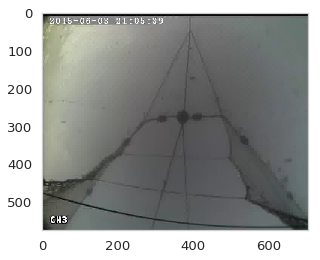

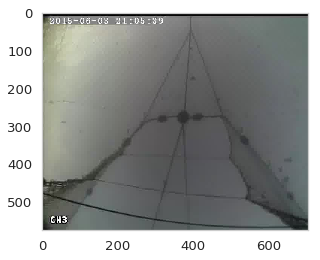

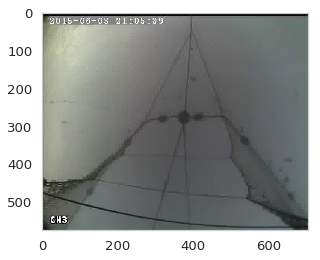

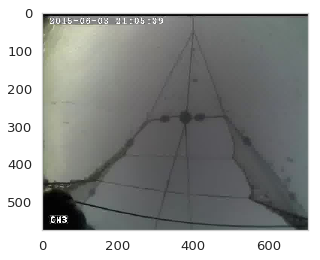

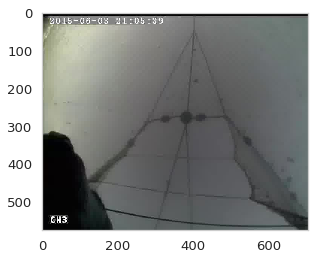

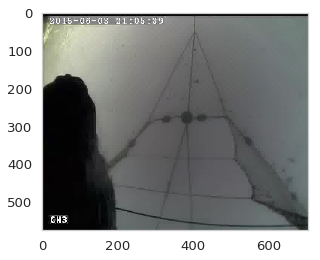

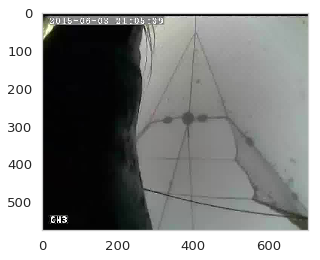

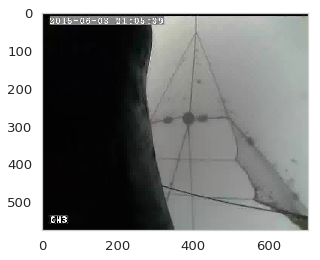

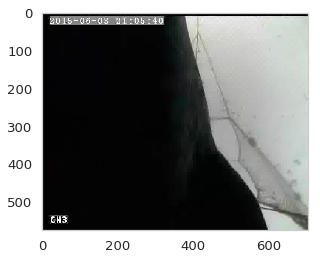

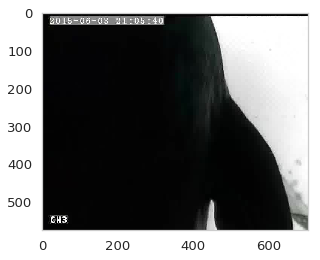

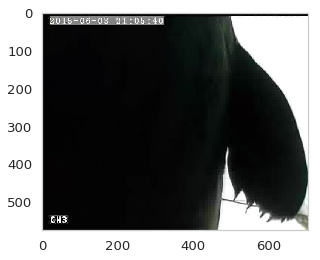

In [75]:
for p in list(dfp.loc[50:60]['path']):
    plot_pic(p)

# Fine-tune pre-trained CNN Model on Frames

https://github.com/raghakot/keras-resnet/blob/master/resnet.py

In [15]:
from keras.applications.xception import preprocess_input as preprocess_xception

## Setup batches

In [16]:
batch_size = 32

In [17]:
img_width = 299
img_height = 299

In [18]:
# define data load generators - apply transformations to distort training images (effectively creates more data)
train_gen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.1,
    preprocessing_function=preprocess_xception
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_xception
)

# create objects that allow us to fetch data in batches
train_batches = train_gen.flow_from_directory(
    path_data_train,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    class_mode='binary'
)

valid_batches = test_gen.flow_from_directory(
    path_data_valid,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    shuffle=False,
    class_mode='binary'
)

test_batches = test_gen.flow_from_directory(
    path_data_test,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    shuffle=False,
    class_mode='binary'
)

Found 9056 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Found 2610 images belonging to 2 classes.


## setup model

In [19]:
base_model = Xception(include_top=False, input_shape=(img_width, img_height, 3))

ft_map = base_model.get_layer(index=-2).output

x = Conv2D(128, (3,3), padding='same')(ft_map)

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='same')(x)

x = GlobalAveragePooling2D()(x)
x = Dense(train_batches.num_class, activation='softmax')(x)


model = Model(base_model.input, x)

In [20]:
# freeze all the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# opt = Adam(0.001)#, momentum=0.9)
opt = Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
len(model.layers)

137

## fit (fine-tune) model 1 on our data

***NB: Once the model has been trained, it can be loaded instead of training by skipping the train lines below and just running the last load_weights line:***

> model.load_weights(path_models + model_name + '_BEST_' + '.hdf5')

In [23]:
model_name = 'Xception'

In [ ]:
# define keras model checkpointer to save best model (highets val_acc)
checkpointer = ModelCheckpoint(path_models + model_name + '_BEST_.hdf5', 
                                monitor='val_acc', 
                                save_best_only=True,
                                save_weights_only=True)

In [ ]:
history = model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
#                    epochs=10,                    
                    epochs=5,                    
                    verbose=1, 
                    validation_data= valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    callbacks = [checkpointer])

In [24]:
# load weights from best epoch (saved by checkpointer)
model.load_weights(path_models + model_name + '_BEST_.hdf5')

In [25]:
print (model.metrics_names)
model.evaluate_generator(valid_batches, np.ceil(valid_batches.samples/batch_size), verbose=1)

['loss', 'acc']


[0.22130587486305622, 0.92045454545454541]

## train some more

In [ ]:
# unfix some later layers and train those (only now after we've trained just the last layer for a while to avoid catastrophic forgetting)
model.layers[-7].trainable = True
model.layers[-8].trainable = True
model.layers[-9].trainable = True
model.layers[-10].trainable = True

In [ ]:
opt = Adam(lr = 0.0001)#, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_batches, 
                    steps_per_epoch=np.ceil(train_batches.samples/batch_size), 
                    epochs=20,                    
                    verbose=1, 
                    validation_data= valid_batches, 
                    validation_steps=np.ceil(valid_batches.samples/batch_size),
                    callbacks = [checkpointer])

> left this running overnight and didn't keep updating the progress but converged to validation accuracy of 92% - probably wanna re-run for longer and check convergence graphs

In [ ]:
# load best from checkpointer (last epoch may not have been the best one)
model.load_weights(path_models + model_name + '_BEST_' + '.hdf5')

In [ ]:
print (model.metrics_names)
model.evaluate_generator(valid_batches, np.ceil(valid_batches.samples/batch_size), verbose=2)

## demo using model to predict frame

In [ ]:
test_img_path = path_data_train +'seal/' + 's37-3930-00054.jpeg'
img = plt.imread(test_img_path)
plt.imshow(img)

# load img in correct format for model
_img = preprocess_xception(image.img_to_array(image.load_img(test_img_path, target_size = (299,299))))
_img = np.stack([_img])

In [ ]:
_preds = model.predict(_img)
_preds

# Precompute model activation outputs to use to then train LSTM

> inspired by https://github.com/harvitronix/five-video-classification-methods

## can re-use same base model

In [26]:
ft_map = base_model.get_layer(index=-2).output

x = Conv2D(128, (3,3), padding='same')(ft_map)

x = BatchNormalization()(x)
x = Flatten()(x)

# model_top.add(Dense(len(np.unique(train_labels)), activation='softmax'))
# x = Dense(64, activation='relu')(x)
# predictions = Dense(10, activation='softmax')(x)

model_activations = Model(base_model.input, x)

## demo using model_activations

In [ ]:
# run img through model and get activations
activations = model_activations.predict(_img)
activations = list(activations[0])

print ("first 5 activations out of {} activations:".format(len(activations)))
print (activations[0:5])

In [84]:
batch_size = 128

In [27]:
# define data load generators - apply transformations to distort training images (effectively creates more data)
train_gen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.1,
    preprocessing_function=preprocess_xception
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_xception
)

# create objects that allow us to fetch data in batches
train_batches = train_gen.flow_from_directory(
    path_data_train,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    class_mode='binary'
)

valid_batches = test_gen.flow_from_directory(
    path_data_valid,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    shuffle=False,
    class_mode='binary'
)

test_batches = test_gen.flow_from_directory(
    path_data_test,
    batch_size=batch_size,
    target_size = (img_width, img_height),
    shuffle=False,
    class_mode='binary'
)

Found 9056 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Found 2610 images belonging to 2 classes.


In [28]:
mapping = train_batches.class_indices
mapping_inv = {v: k for k, v in mapping.items()}
mapping_inv

{0: 'noseal', 1: 'seal'}

In [29]:
nb_train_seal = len(os.listdir(path_data_train + '/seal/'))
nb_train_noseal = len(os.listdir(path_data_train + '/noseal/'))
#
nb_valid_seal = len(os.listdir(path_data_valid + '/seal/'))
nb_valid_noseal = len(os.listdir(path_data_valid + '/noseal/'))
#
nb_train_samples = nb_train_seal + nb_train_noseal
nb_valid_samples = nb_valid_seal + nb_valid_noseal
#
print ("train: {} ... seal: {} noseal: {}".format(nb_train_samples, nb_train_seal, nb_train_noseal))
print ("valid: {} ... seal: {} noseal: {}".format(nb_valid_samples, nb_valid_seal, nb_valid_noseal))      

train: 9058 ... seal: 2996 noseal: 6062
valid: 792 ... seal: 402 noseal: 390


In [30]:
### BOTTLENECK FEATURES: TRAIN 
if os.path.exists(path_models + 'seals_bottleneck_features_train.npy'):
    print("opening previously computed bottleneck features from file: TRAIN")
    train_data = np.load(open(path_models + 'seals_bottleneck_features_train.npy', 'rb'))
else:
    print("Computing bottleneck features: TRAIN")
    train_data = model_activations.predict_generator(train_batches, train_batches.n//batch_size, verbose = 1)
    np.save(open(path_models + 'seals_bottleneck_features_train.npy', 'wb'), train_data)

# split out labels
train_labels = np.array([(1,0)] * nb_train_seal + [(0,1)] * nb_train_noseal)

opening previously computed bottleneck features from file: TRAIN


In [31]:
### BOTTLENECK FEATURES: TEST 
if os.path.exists(path_models + 'seals_bottleneck_features_test.npy'):
    print("opening previously computed bottleneck features from file: TEST")
    validation_data = np.load(open(path_models + 'seals_bottleneck_features_test.npy', 'rb'))
else:
    print("Computing bottleneck features: TEST")
    validation_data = model_activations.predict_generator(valid_batches, valid_batches.n/batch_size, verbose = 1)
    np.save(open(path_models + 'seals_bottleneck_features_test.npy', 'wb'), validation_data)

# split out labels
validation_labels = np.array([(1,0)] * nb_valid_seal + [(0,1)] * nb_valid_noseal)

opening previously computed bottleneck features from file: TEST


In [32]:
# batching may lead to dropping off last few rows if sample size not divisible by batch size 
# this fix is ghetto but works
train_labels = train_labels[:len(train_data),:]
validation_labels = validation_labels[:len(validation_data),:]

In [33]:
# # # reshape
# train_data = np.expand_dims(train_data, axis=0)
# validation_data = np.expand_dims(validation_data, axis=0)

In [34]:
train_data.shape, train_labels.shape

((9056, 12800), (9056, 2))

In [35]:
validation_data.shape, validation_labels.shape

((792, 12800), (792, 2))

> reshape for LSTM

In [36]:
features_length = 12800
seq_length = 10

In [37]:
x_train = []

for i in range(len(train_data)):
    if i >seq_length:
#         print(i)
        new = train_data[i:seq_length + i,:]
        if new.shape[0] == seq_length:
            x_train.append(new)
            
x_train = np.stack(x_train, axis=0)

In [38]:
x_valid = []

for i in range(len(validation_data)):
    if i >seq_length:
        new = validation_data[i:seq_length + i,:]
        if new.shape[0] == seq_length:
            x_valid.append(new)
            
x_valid = np.stack(x_valid, axis=0)

In [39]:
train_labels = train_labels[seq_length:len(train_labels)-seq_length,:]
validation_labels = validation_labels[seq_length:len(validation_labels)-seq_length,:]

In [40]:
train_labels.shape

(9036, 2)

In [41]:
x_valid.shape, validation_labels.shape

((772, 10, 12800), (772, 2))

In [42]:
# shuffle transormed training data now that it's batched into sequences of frames
from sklearn.utils import shuffle
x_train, train_labels = shuffle(x_train,train_labels)

In [43]:
batch_size = 128

In [44]:
model_name = 'LSTM_Xception'

In [45]:
model_LSTM = Sequential()
model_LSTM.add(SimpleRNN(256, return_sequences=False,
               input_shape=(seq_length, features_length),
               dropout=0.3))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(Dense(train_batches.num_class, activation='softmax'))

In [46]:
model_LSTM.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# define keras model checkpointer to save best model (highets val_acc)
checkpointer = ModelCheckpoint(path_models + model_name + '_BEST_.hdf5', 
                                monitor='val_acc', 
                                save_best_only=True,
                                save_weights_only=True)

#model.load_weights('video_1_LSTM_1_512.h5')
model_LSTM.fit(x_train,train_labels,
          validation_data=(x_valid,validation_labels),
          batch_size=batch_size,
          nb_epoch=500,
          callbacks=[checkpointer],
          shuffle=True,
          verbose=1)

Train on 9036 samples, validate on 772 samples
Epoch 1/500
 256/9036 [..............................] - ETA: 5s - loss: 0.6309 - acc: 0.6914

/home/ec2-user/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


5376/9036 [================>.............] - ETA: 2s - loss: 0.6359 - acc: 0.6754

In [ ]:
model_LSTM.save_weights(path_models + model_name + '_BEST_.hdf5')

# Evaluate models

## predict on validation set

In [ ]:
from PIL import Image

In [ ]:
labels_true = []
imgs = []
paths = []

# debug
cc = 0

for root, dirs, files in os.walk(path_data_valid, topdown=False):
    for name in files:

        # debug
        if cc < 100:
            cc+=1
        
            _path = os.path.join(root, name)
            paths.append(_path)

            print(_path)
            
            imgs.append(inception_v3_preprocessor((image.load_img(_path, target_size = (299,299)))))

            label = 1
            if 'noseal' in _path:
                label = 0

            #print(_path, label_map[label], label)

            labels_true.append(label)

In [ ]:
imgs = np.stack(imgs)
preds = model.predict(imgs)

In [ ]:
# calculate time taken to compute predictions
pred_count = imgs.shape[0]
time_taken = 69 #seconds
print ("Predictions per second: {}".format(pred_count/time_taken))

In [ ]:
# note preds is just the 3 probabilities
preds

In [ ]:
pred_labels = np.argmax(preds,axis = 1)

dfp = pd.DataFrame(preds)
dfp = pd.concat([dfp,pd.Series(pred_labels)], axis = 1)
dfp = pd.concat([dfp,pd.Series(paths)], axis = 1)
dfp.columns = ['p_accept','mild','hard','pred_label','filename']

dfp['pred_label_name'] = dfp["pred_label"].map(label_map)

dfp['truth'] = pd.Series(labels_true)
dfp['truth'] = dfp["truth"].map(label_map)

dfp['error'] = (dfp['pred_label_name'] != dfp['truth']).astype(int)

In [ ]:
dfp

## Plot confusion matrix

### define function to make confusion matrix plot

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### plot confusion matrix

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels_true, pred_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(label_map.values()),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(label_map.values()), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

**<font color='blue' size='14px'>Comment:</font>**

* <font color='blue'> The "confusion matrix" above shows truth vs predictions for all 3 classes </font>


* <font color='blue'> The first 3x3 block shows raw counts and the second normalized block shows proportions</font>


* <font color='blue'> For example, 1% of images that *are* "hard" are labelled as "accept" and 10% of "hard" images are labelled as "mild"</font>


* <font color='blue'> Bear in mind, we're using a majority threshold to predict classes i.e. predict hard if probability_hard > 1/3 ... we will tune this later to increase the hard class true positive rate (at the expense of more false positives)</font>

## View examples of images the model got wrong

In [ ]:
def plot_pic_grid_files(filenames, add_title=True):
    # set figsize
    fig = plt.figure()
    fig.set_size_inches((16,8))

    plotted = 0

    for c, r in enumerate(filenames):

        # get path to image file 
        img_path_on_disk = r

        if len(img_path_on_disk) > 0:    

            if plotted < 10:

                plotted+=1

                # plotting 10 images
                a = fig.add_subplot(2, 5, (plotted))
                img= plt.imread(img_path_on_disk)
                imgplot = a.imshow(img)
                if add_title: 
                    a.set_title(r.split("/").pop())

                #print user_id, 'image plotted'
        else:
            # print user_id, 'no pic available'
            pass

### truth == "hard" but model predicted "accept" <-> FALSE NEGATIVE

In [ ]:
filenames = list(dfp[(dfp['truth'] == 'hard') & (dfp['pred_label_name'] == 'accept')].filename)
plot_pic_grid_files(filenames[0:10])

In [ ]:
filenames

### truth == "accept" but model predicted "hard" <-> FALSE POSITIVE

In [ ]:
filenames = list(dfp[(dfp['truth'] == 'accept') & (dfp['pred_label_name'] == 'hard')].filename)
plot_pic_grid_files(filenames[0:10])

In [ ]:
filenames

### truth == "hard" but model predicted "mild" <-> SEMI-FALSE NEGATIVE

In [ ]:
filenames = list(dfp[(dfp['truth'] == 'hard') & (dfp['pred_label_name'] == 'mild')].filename)
plot_pic_grid_files(filenames[0:10])

In [ ]:
plot_pic_grid_files(filenames[10:20])

## Plot probability densities for each of the 3 truth classes

In [ ]:
# TODO

In [ ]:
# we've already got the prediction probabilities in a dataframe
# let's drop the preds done using majority labelling and first plot the densities then do an ROC plot and optimize the probability_hard cutoff
del dfp['pred_label_name']
del dfp['error']
dfp.columns = ['prob_accept', 'prob_mild', 'prob_hard', 'pred_label', 'filename', 'truth']

dfp.head()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10), ncols=3, nrows=1)

# The amount of space above titles
y_title_margin = 1

ax[0].set_title("Accept", y = y_title_margin)
ax[1].set_title("Mild", y = y_title_margin)
ax[2].set_title("Hard", y = y_title_margin)

plt.suptitle("Predicted class probabilities subset by truth label in validation set", y = 1.05, fontsize=20)

### ACCEPT
sns.swarmplot(dfp[dfp['truth'] == 'accept']['prob_accept'], ax = ax[0])
sns.swarmplot(dfp[dfp['truth'] == 'accept']['prob_mild'], ax = ax[0])
sns.swarmplot(dfp[dfp['truth'] == 'accept']['prob_hard'], ax = ax[0])

### MILD
sns.swarmplot(dfp[dfp['truth'] == 'mild']['prob_accept'], ax = ax[1])
sns.swarmplot(dfp[dfp['truth'] == 'mild']['prob_mild'], ax = ax[1])
sns.swarmplot(dfp[dfp['truth'] == 'mild']['prob_hard'], ax = ax[1])

### HARD
sns.swarmplot(dfp[dfp['truth'] == 'hard']['prob_accept'], ax = ax[2])
sns.swarmplot(dfp[dfp['truth'] == 'hard']['prob_mild'], ax = ax[2])
sns.swarmplot(dfp[dfp['truth'] == 'hard']['prob_hard'], ax = ax[2])

# Plot ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
# join mild and accept into 1 class so ROC curve plots hard vs non-hard reject
labels_true_bin = labels_true
labels_true_bin = np.array(labels_true_bin)
labels_true_bin[labels_true_bin == 2] = 0

pred_labels_bin = pred_labels
pred_labels_bin = np.array(pred_labels_bin)
pred_labels_bin[pred_labels_bin == 2] = 0

In [ ]:
# Compute confusion matrix
roc = roc_curve(labels_true_bin, pred_labels_bin)

In [ ]:
fpr, tpr, threshold = roc_curve(labels_true_bin, pred_labels_bin)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
roc_cutoff = fpr[1]
roc_cutoff

## Re-calculate Predictions using new hard class prediction cutoff

In [ ]:
roc_cutoff = 0.15

In [ ]:
# define function to get confusion matrix for variou cutoff values
def get_cnf_matrix(roc_cutoff):
    dfp2 = dfp.copy()

    # predict hard if p_hard > roc_cutoff else predict majority between accept and mild
    dfp2['pred_label_name'] = np.nan
    dfp2['pred_label_name'] = np.where(dfp2['hard'] > roc_cutoff, 'hard', np.nan)

    dfp2.loc[(dfp2['pred_label_name'] == 'nan') & (dfp2['p_accept'] > dfp2['mild']), 'pred_label_name'] = 'accept'
    dfp2.loc[(dfp2['pred_label_name'] == 'nan') & (dfp2['p_accept'] <= dfp2['mild']), 'pred_label_name'] = 'mild'

    cnf_matrix = confusion_matrix(list(dfp2['truth']), list(dfp2['pred_label_name']))

    # accept mis-labelled as hard
    false_positive = cnf_matrix[0,1] / (cnf_matrix[0,0] + cnf_matrix[0,1] + cnf_matrix[0,2])
    # accept mis-labelled as hard
    false_negative = cnf_matrix[1,0] / (cnf_matrix[1,0] + cnf_matrix[1,1] + cnf_matrix[1,2])
    #
    print ("Cutoff: {} ... False positive: {}, False negative: {}".format(roc_cutoff, round(false_positive,3), round(false_negative,3)))
    
    return cnf_matrix

> scan range of roc cutoffs and view fale positive / false negative trade-offs

In [ ]:
for roc_cutoff in range(5,35,1):
    get_cnf_matrix(roc_cutoff/100)

## Plot confusion matrix using new cutoff

In [ ]:
roc_cutoff = 0.33

In [ ]:
# Compute confusion matrix
#cnf_matrix = confusion_matrix(list(dfp2['truth']), list(dfp2['pred_label_name']))
cnf_matrix = get_cnf_matrix(roc_cutoff)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(label_map.values()),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(label_map.values()), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# pred_labels = np.argmax(preds,axis = 1)

# dfp = pd.DataFrame(preds)
# dfp = pd.concat([dfp,pd.Series(pred_labels)], axis = 1)
# dfp = pd.concat([dfp,pd.Series(paths)], axis = 1)
# dfp.columns = ['p_accept','mild','hard','pred_label','filename']

# dfp['pred_label_name'] = dfp["pred_label"].map(label_map)

# dfp['truth'] = pd.Series(labels_true)
# dfp['truth'] = dfp["truth"].map(label_map)

# dfp['error'] = (dfp['pred_label_name'] != dfp['truth']).astype(int)

# ETC

In [ ]:
# TODO